# Part 1

Play around with the data and try to see some really strong correlations.

The first move is to view the NBA DataFrame

In [426]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

nba_df = pd.read_csv("nba-2425.csv", skipinitialspace=True)

# Check if there are duplicated players in the DataFrame
is_duplicate = nba_df.duplicated(subset=["Player"], keep=False)
has_duplicates = is_duplicate.isin([True]).any()

# Here I'm not thinking that these duplicates matter 
print(f"There are {'some' if has_duplicates else 'no'} duplicate Players in the DataFrame.\n")

# Grab all the leaguge average data, it's in the last row
league_averages = nba_df.tail(1)

# Now drop the last row
nba_df = nba_df[:-1]

nba_df.info()

nba_df

There are some duplicate Players in the DataFrame.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rk                 735 non-null    float64
 1   Player             735 non-null    object 
 2   Age                735 non-null    float64
 3   Team               735 non-null    object 
 4   Pos                735 non-null    object 
 5   G                  735 non-null    float64
 6   GS                 735 non-null    float64
 7   MP                 735 non-null    float64
 8   FG                 735 non-null    float64
 9   FGA                735 non-null    float64
 10  FG%                731 non-null    float64
 11  3P                 735 non-null    float64
 12  3PA                735 non-null    float64
 13  3P%                690 non-null    float64
 14  2P                 735 non-null    float64
 15  2PA                735

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,Player-additional
0,1.0,Shai Gilgeous-Alexander,26.0,OKC,PG,76.0,76.0,34.2,11.3,21.8,...,4.1,5.0,6.4,1.7,1.0,2.4,2.2,32.7,NaN,gilgesh01
1,2.0,Giannis Antetokounmpo,30.0,MIL,PF,67.0,67.0,34.2,11.8,19.7,...,9.7,11.9,6.5,0.9,1.2,3.1,2.3,30.4,NaN,antetgi01
2,3.0,Nikola Jokić,29.0,DEN,C,70.0,70.0,36.7,11.2,19.5,...,9.9,12.7,10.2,1.8,0.6,3.3,2.3,29.6,NaN,jokicni01
3,4.0,Luka Dončić,25.0,2TM,PG,50.0,50.0,35.4,9.2,20.5,...,7.4,8.2,7.7,1.8,0.4,3.6,2.5,28.2,NaN,doncilu01
4,4.0,Luka Dončić,25.0,DAL,PG,22.0,22.0,35.7,9.8,21.2,...,7.6,8.3,7.8,2.0,0.4,3.4,2.6,28.1,NaN,doncilu01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,565.0,Riley Minix,24.0,SAS,SF,1.0,0.0,7.0,0.0,1.0,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,minixri01
731,566.0,Jahlil Okafor,29.0,IND,C,1.0,0.0,3.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,okafoja01
732,567.0,Zyon Pullin,23.0,MEM,SG,3.0,0.0,1.0,0.0,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,pullizy01
733,568.0,Isaiah Stevens,24.0,MIA,PG,3.0,0.0,2.0,0.0,0.7,...,0.7,0.7,0.0,0.3,0.0,0.0,0.0,0.0,NaN,steveis01


Now I want to look at some columns to see what's going on. 

Later in the process, I'm noticing that there are some NaN values for some players (especially towards the bottom of the rankings), implying that they never got opportunities to do certain players (like shoot 3's), which means that their percentages can't be calculated.

To fix this, it might be useful to replace all NaN values with zero, because for all intents and purposes it IS zero lol.

In [427]:
all_cols = nba_df.columns.to_list()
print(all_cols)

nba_df = nba_df.fillna(0)

['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Awards', 'Player-additional']


I think I'm going to eliminate some columns that logically speaking are not going to be helpful for determining rank.

- `Player-additional` contains no useful data on player performance
- `Team` shouldn't be a category that affect their team performance
- `Awards` is empty for all players
- `Player` Player names don't give us an indication about how well they play, two players with the same common name could perform very differently.

Some features I'm curious about in terms of correlation to rank
- `Pos` maybe point guards are on average ranked higher than centers. 

In [428]:
nba_df = nba_df.drop(labels=["Player-additional", "Awards", "Team"], axis=1)

# Remove these columns from all_cols
all_cols.remove("Player-additional")
all_cols.remove("Team")
all_cols.remove("Awards")
print(f"Updated Columns: {all_cols}\n")

nba_df

Updated Columns: ['Rk', 'Player', 'Age', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']



,Rk,Player,Age,Pos,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1.0,Shai Gilgeous-Alexander,26.0,PG,76.0,76.0,34.2,11.3,21.8,0.519,...,0.898,0.9,4.1,5.0,6.4,1.7,1.0,2.4,2.2,32.7
1,2.0,Giannis Antetokounmpo,30.0,PF,67.0,67.0,34.2,11.8,19.7,0.601,...,0.617,2.2,9.7,11.9,6.5,0.9,1.2,3.1,2.3,30.4
2,3.0,Nikola Jokić,29.0,C,70.0,70.0,36.7,11.2,19.5,0.576,...,0.800,2.9,9.9,12.7,10.2,1.8,0.6,3.3,2.3,29.6
3,4.0,Luka Dončić,25.0,PG,50.0,50.0,35.4,9.2,20.5,0.450,...,0.782,0.8,7.4,8.2,7.7,1.8,0.4,3.6,2.5,28.2
4,4.0,Luka Dončić,25.0,PG,22.0,22.0,35.7,9.8,21.2,0.464,...,0.767,0.7,7.6,8.3,7.8,2.0,0.4,3.4,2.6,28.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,565.0,Riley Minix,24.0,SF,1.0,0.0,7.0,0.0,1.0,0.000,...,0.000,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
731,566.0,Jahlil Okafor,29.0,C,1.0,0.0,3.0,0.0,0.0,0.000,...,0.000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
732,567.0,Zyon Pullin,23.0,SG,3.0,0.0,1.0,0.0,0.3,0.000,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
733,568.0,Isaiah Stevens,24.0,PG,3.0,0.0,2.0,0.0,0.7,0.000,...,0.000,0.0,0.7,0.7,0.0,0.3,0.0,0.0,0.0,0.0


Now I want to look at and plot the relationships between every other column and player rank. To handle the position visualizations, I want to convert the position into numbers 

Age vs Rank: -0.15
Pos vs Rank: 0.06
G vs Rank: -0.55
GS vs Rank: -0.72
MP vs Rank: -0.9
FG vs Rank: -0.92
FGA vs Rank: -0.92
FG% vs Rank: -0.25
3P vs Rank: -0.71
3PA vs Rank: -0.73
3P% vs Rank: -0.31
2P vs Rank: -0.82
2PA vs Rank: -0.84
2P% vs Rank: -0.22
eFG% vs Rank: -0.27
FT vs Rank: -0.79
FTA vs Rank: -0.78
FT% vs Rank: -0.42
ORB vs Rank: -0.34
DRB vs Rank: -0.7
TRB vs Rank: -0.63
AST vs Rank: -0.7
STL vs Rank: -0.66
BLK vs Rank: -0.39
TOV vs Rank: -0.79
PF vs Rank: -0.68
PTS vs Rank: -0.92


<Figure size 1600x3000 with 0 Axes>

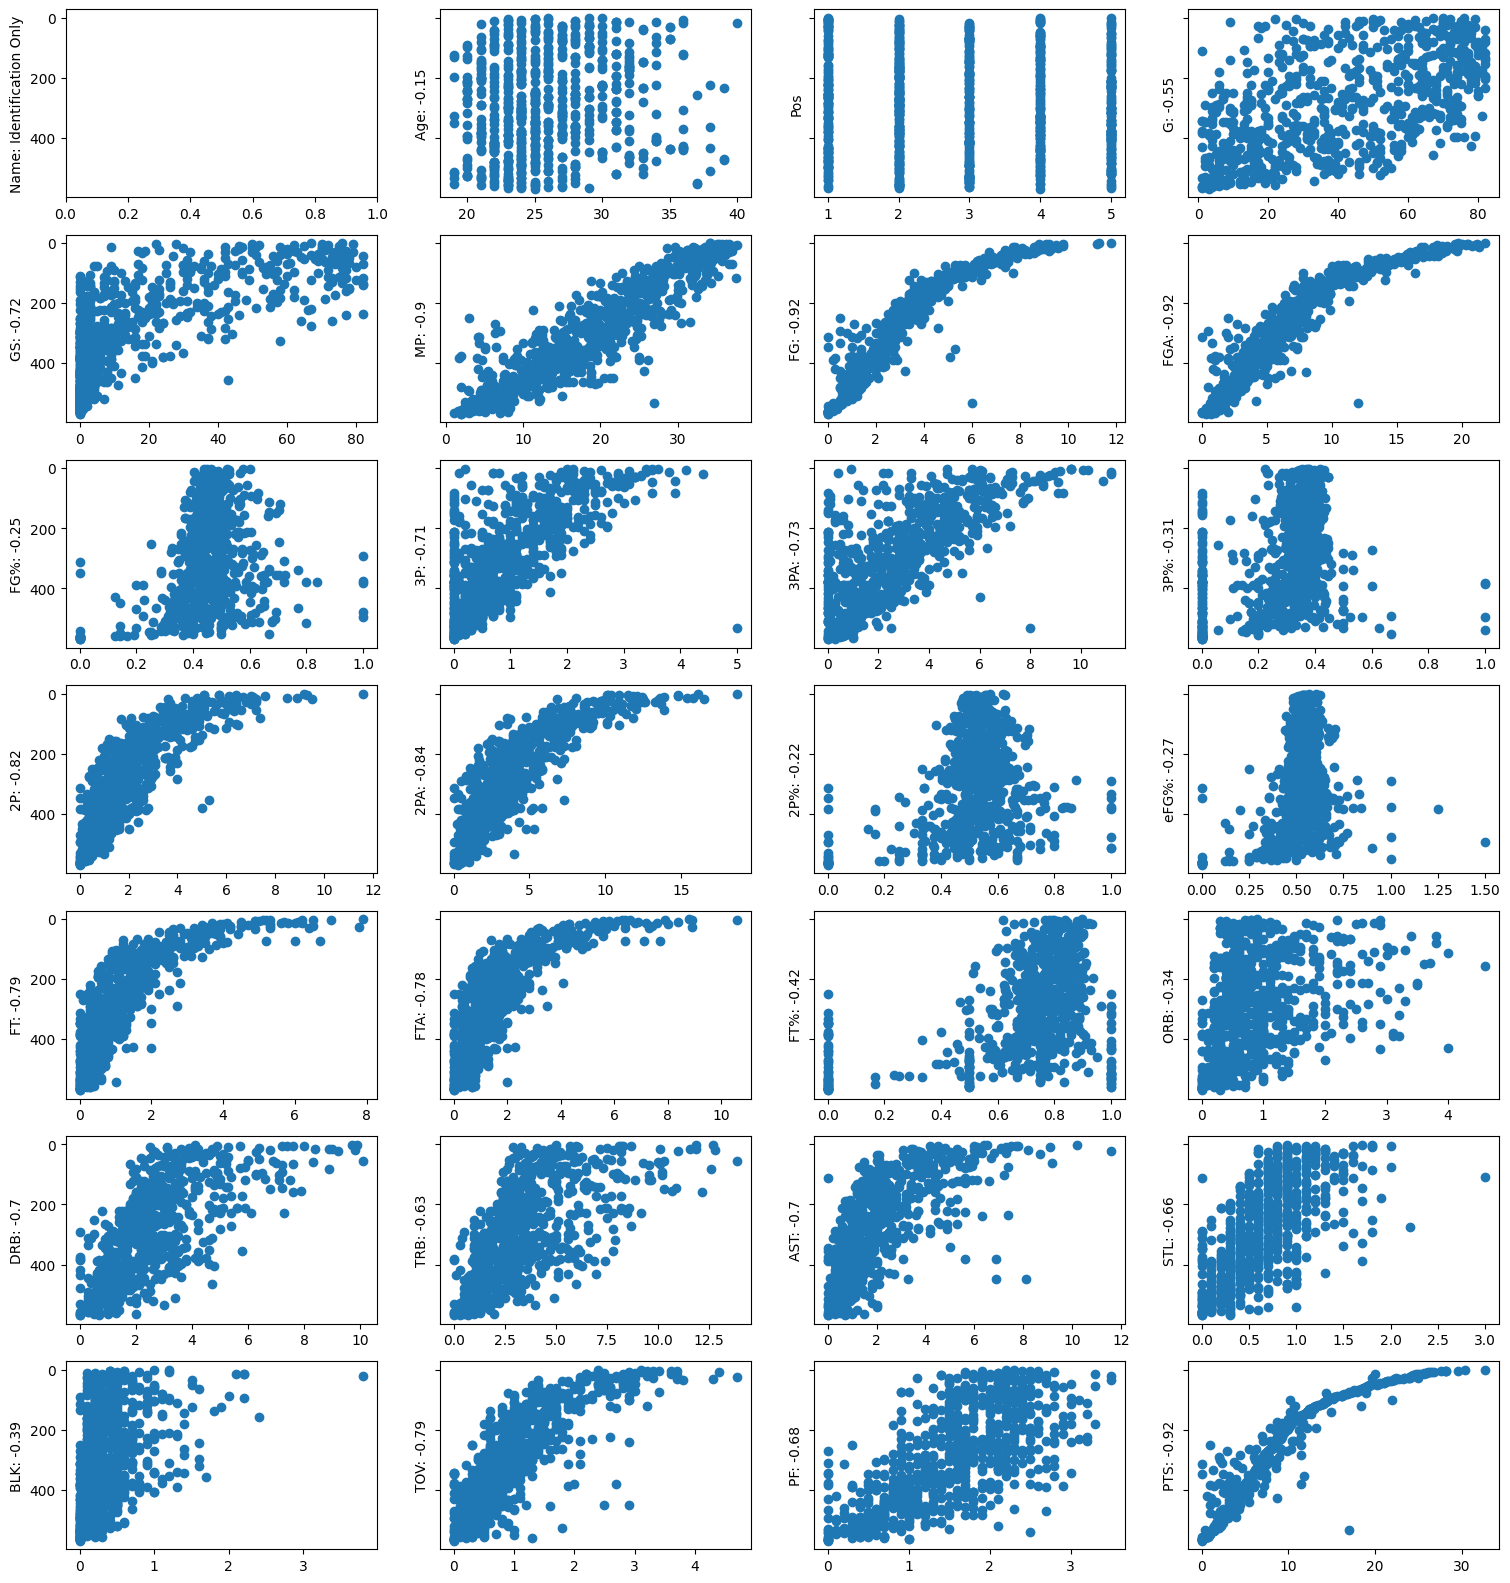

In [429]:
# Convert the player's position into numbers according
# to the traditional NBA sense.
def get_num(pos):
    if pos == "PG":
        return 1
    if pos == "SG":
        return 2
    if pos == "SF":
        return 3
    if pos == "PF":
        return 4
    else: # Must be center
        return 5


plt.figure(figsize=(16, 30))
# Make list of correlations:
all_cors = []

# There are 28 other columns 
fig, axes = plt.subplots(7, 4, sharey=True)
fig.set_size_inches(18.5, 20)
index = 1
num_players = nba_df.shape[0]
for row in range(0, 7):
    for col in range(0, 4):
        current_col = nba_df[all_cols[index]]
        # Plot numerical data as scatter plot
        # Plot categorical data as  
        if (current_col.dtype != "object"):
            correlation = current_col.corr(nba_df["Rk"])
            axes[row, col].scatter(current_col, nba_df["Rk"])
            axes[row, col].set_ylabel(f"{current_col.name}: {round(correlation, 2)}")
            axes[row, col].invert_yaxis()
            all_cors.append(correlation)
            print(f"{current_col.name} vs Rank: {round(correlation, 2)}")
        elif current_col.name == "Pos":
            position_numbers = current_col.apply(get_num)
            correlation = position_numbers.corr(nba_df["Rk"])
            axes[row, col].scatter(position_numbers, nba_df["Rk"])
            axes[row, col].set_ylabel(current_col.name)
            axes[row, col].invert_yaxis()
            all_cors.append(correlation)
            print(f"{current_col.name} vs Rank: {round(correlation, 2)}")
        else:
            all_cors.append(0)
            axes[row, col].set_ylabel("Name: Identification Only")
            

        index += 1

### Interpretations

NOTE: I'm going to be considering a correlation coefficient (absolute value) of over 0.75 to indicate strong correlation however, I'll also be taking a look at the data, cuz the correlation coefficient isn't as strong of a signal for correlation non-linear data, and there's some pretty non-linear looking data.

After taking a look at the data, I learned a few things.

Complete Non-starters:
- It looks like `Pos` (player position) pretty much doesn't matter as a whole in determining player ranking.
- `G` (games played) also looked to be pretty much noise not going to lie.
- `eFG%` (effective field goal percentage), **I'm not really sure why this is.** I don't fully understand the statistic though
- `ORB` (offensive rebounds) also looks to be a pretty bad indicator.
- `Age`, contrary to my belief, age doesn't really seem to be an indicator of a players performance/rank. In fact we see a kind of similar distribution of player ranks across the age bands. Unsurpringly, the NBA players age data tends to concentrate in the early 20s, with a pretty steep dropoff after 30. Of course we have an outlier in the age category, LeBron.
- `FT%` (free throw percentages), yea this is not very helpful at all. I'm guessing that in order to even be in the NBA, a player would already have to be elite at free throws, and there's not much utility in improving free throw efficiency compared to other parts of the game. 
- `2P%` (2 point percentage). This is also a surprisingly bad indicator of a player's rank. I'm thinking this is because of volume differences. Role players who might not shoot a lot of 2 point attempts may see an artificially increased 2 point percentange because of this.

Potential Features (with some modifications):
- `FG%` (field goal percentage), there are a decent amount of outliers that make it hard to see if there's a clear relationship. What's interesting is that `FGA` (field goal attempts) looks to be a far better indicator of rank than field goal percentage. I think this might be because teams allow their better players to take more shots than worse players.
- `BLK` (blocks) not going to lie, I'm not seeing anything to strong, but this might just be super hard to visualize because of the complete outlier
- `STL`(steals) I think if we get rid of the outlier data, we can definitely get a stronger signal for this.

Interesting Things to Note:
- `TOV` (turnovers), the more turnovers a person has generally speaking, the higher their player rank. I'm guessing this is because star players usually have the ball in their hands a lot more which implies that there are more opportunities to turn over the ball. However, this goes against our intuitions, and if we have two players with comparable stats, it makes no sense to dock a person for their player 
- `PF` (personal foulds) has a weakly positive correlation with player rank, implying that the more personal fouls per game a person elicits, the better they seem to be, this might be becuase better players get more minutes per game, which exposes them to more situations in which they commit a personal foul.
- `ORB` vs `DRB` **it's weird how** offensive rebounding results in a far weaker signal of player rank than defensive rebounding. I'm actually not even sure why this is. I think I'll have to consult some friends who know ball better than I do. 

### Some Next Steps:

I'm going to remove the complete non-starters, and try to reduce the outliers so I can accurately view if there ar some strong signals.

Procedure to drop the outliers for a `column`:
- First calculate the regresison line between `column` and player rank
- Then compute each player's distance to this computed regression line (storing the values in a new column)
- Then find the players corresponding to the 10 largest distances and set their values to NA
- Now we compute the mean non-NA values for the column
- Then, we replace the NA values with our new NA values 

Correcting FG% stats ...
Correcting BLK stats ...
Correcting STL stats ...
Correlation b/w Rank and FG%: -0.3185314844778412
Correlation b/w Rank and BLK: -0.3762329239662626
Correlation b/w Rank and STL: -0.6761058737277361


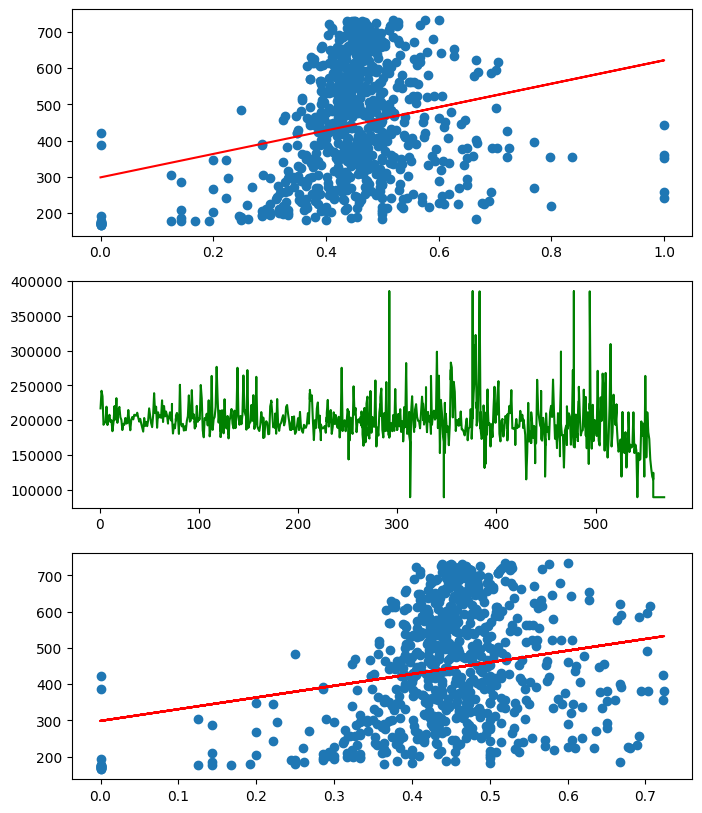

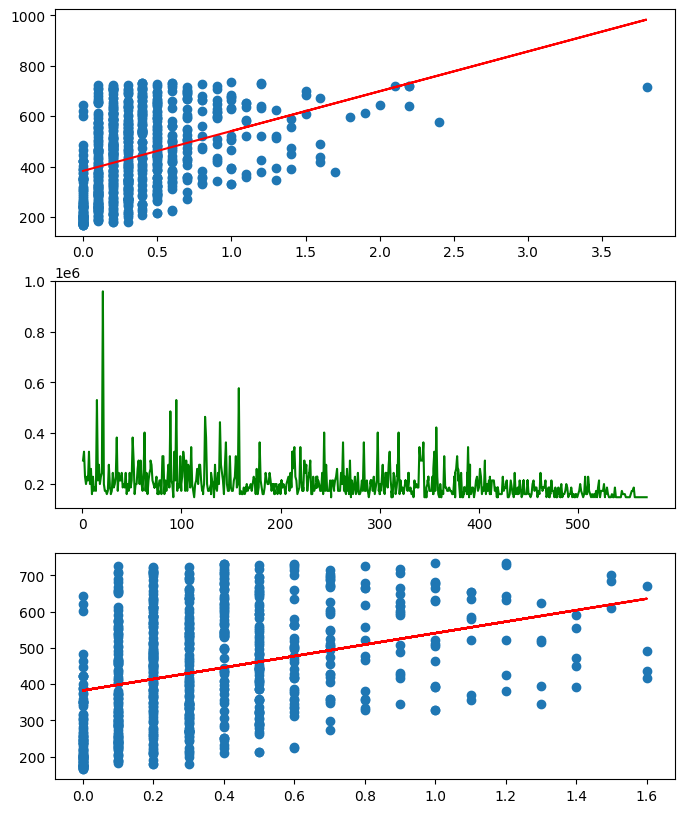

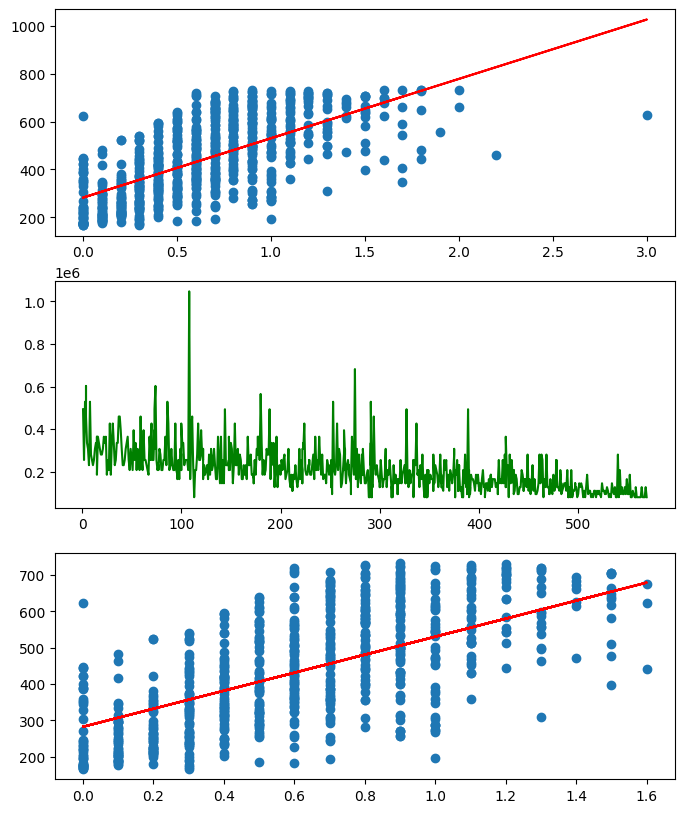

In [430]:
# Delete the complete non-starters
nba_df = nba_df.drop(labels=["Pos", "G", "eFG%", "ORB", "FT%", "Age", "2P%"], axis=1)

# Now drop the outliers in the potential features
def remove_outliers(df, column, num_outliers=10):
    # Calculate regression line b/w column and player rank
    model = LinearRegression().fit(df[[column]], (df[["Rk"]] - num_players) * -1)
    df["predicted"] = model.predict(df[[column]])

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    fig.set_size_inches(8, 10)

    # Plot the regression line vs actual data
    # But maybe the data isn't visualized as wel as I'd have liked
    ax1.plot(df[column], df["predicted"], color="red")
    ax1.scatter(df[column], num_players - df["Rk"])

    # Plot distance to regression line as a function of rank, just to see if the outliers are higher or lower ranked
    df["dists"] = (df["predicted"] - df[column]) ** 2
    ax2.plot(df["Rk"], df["dists"], color="green")

    # Remove hte 10 largest outliers in df[column], and replace them with the new mean value
    outlier_indices = df.nlargest(num_outliers, "dists").index.to_list()
    for index in outlier_indices:
        df.loc[index, column] = np.nan
    mean_value = df[column].mean()
    df.fillna(mean_value)

    # Now plot the modified df[column] vs rank as well as the regression line
    # Now we see better fit, and we can try looking at the correlation
    ax3.scatter(df[column], num_players - df["Rk"])
    ax3.plot(df[column], df["predicted"], color="red")


# Now correct all these
print("Correcting FG% stats ...")
remove_outliers(nba_df, "FG%")

print("Correcting BLK stats ...")
remove_outliers(nba_df, "BLK")

print("Correcting STL stats ...")
remove_outliers(nba_df, "STL", 20)

# Now we can re-compute correlations between
print(f"Correlation b/w Rank and FG%: {nba_df['FG%'].corr(nba_df['Rk'])}")
print(f"Correlation b/w Rank and BLK: {nba_df['BLK'].corr(nba_df['Rk'])}")
print(f"Correlation b/w Rank and STL: {nba_df['STL'].corr(nba_df['Rk'])}")


Okay looking at `BLK` and `FG%`, we can see that the outliers were hiding a pretty low correlation